# Hiragana Handwritten Character Classification
## CS-UY 4563: Introduction to Machine Learning
### Samuel Jimenez Canizal
**Dataset:** Handwritten Japanese Hiragana Characters  
**Models:** Logistic Regression, K-Nearest Neighbors, Neural Network  

## IMPORTS
This section imports all necessary libraries. All the dependencies are listed in 'requirements.txt' and are installed inside a virtual environment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from constants import HIRAGANA_MAP, PHONETIC_LABELS

In [2]:
data_root = Path("data/handwritten-hiragana")

## Feature Extraction

In this section I convert each image into a numeric feature vector. The dataset provides 100 images of each basic character in Hiragana that I will manually engineer into numeric features. Such features include:

- Pixel intensity statistics
- Ink density and bounding box geometry  
- Center of mass  
- Laplacian variance (sharpness)  
- Histogram of Oriented Gradients (HOG) features

This process will produce a 22-feature vector.

In [3]:
def extract_features_from_image(path, target_size = (28, 28)):
    character_image = imread(path)
    if character_image.ndim == 3:
        character_image = rgb2gray(character_image)

    character_image = resize(character_image, target_size, anti_aliasing = True).astype(np.float32)

    mean_val = character_image.mean()
    std_val  = character_image.std()
    min_val  = character_image.min()
    max_val  = character_image.max()

    thresh = character_image.mean()
    ink = character_image < thresh
    ink_count = ink.sum()

    coords = np.argwhere(ink)
    if coords.size > 0:
        (y_min, x_min), (y_max, x_max) = coords.min(0), coords.max(0)
        bbox_height = y_max - y_min + 1
        bbox_width  = x_max - x_min + 1
        bbox_area   = bbox_height * bbox_width
        aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0.0
    else:
        bbox_height = bbox_width = bbox_area = aspect_ratio = 0.0

    com_y, com_x = ndimage.center_of_mass(character_image)

    lap = ndimage.laplace(character_image)
    lap_var = lap.var()

    hog_vec = hog(character_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    hog_short = hog_vec[:10]

    features = np.array([
        mean_val, 
        std_val, 
        min_val, 
        max_val, 
        ink_count, 
        bbox_height, 
        bbox_width, 
        bbox_area, 
        aspect_ratio,
        com_x, 
        com_y,
        lap_var,
        *hog_short
    ], dtype=np.float32)

    return features

In [4]:
image_paths = list(data_root.rglob("*.jpg"))

In [5]:
PHONETIC_TO_ID = {phonetic: i for i, phonetic in enumerate(PHONETIC_LABELS)}

X_list = []
y_list = []

for img_path in tqdm(image_paths):
    class_name = img_path.parent.name

    label_id = PHONETIC_TO_ID[class_name]
    features = extract_features_from_image(img_path)

    X_list.append(features)
    y_list.append(label_id)

X = np.vstack(X_list)
y = np.array(y_list)

X.shape, y.shape

100%|██████████| 4600/4600 [00:35<00:00, 128.02it/s]


((4600, 22), (4600,))

In [6]:
def decode_label(prediction):
  phonetic = PHONETIC_LABELS[prediction]
  return HIRAGANA_MAP.get(phonetic)

## Exploratory Analysis

Before splitting the dataset and training the chosen models, here is some exploratory analysis. The goals of this exploratory analysis is to visualize feature distribution, examine the relationship between features and the target class, inspect the correlation between each feature, and to understand why some features are important to classify characters. Visual representations that will be used to accomplish this include:
- Correlation Matrix
- Density Plots
- Feature vs Target Distribution
- Feature Distribution per Character
- Visuals of Handwritten Characters

In [7]:
feature_columns = [
    "mean_val", "std_val", "min_val", "max_val",
    "ink_count", "bbox_height", "bbox_width", "bbox_area",
    "aspect_ratio", "com_x", "com_y", "lap_var",
    "hog_0", "hog_1", "hog_2", "hog_3", "hog_4",
    "hog_5", "hog_6", "hog_7", "hog_8", "hog_9",
]

df = pd.DataFrame(X, columns = feature_columns)
df["label"] = y

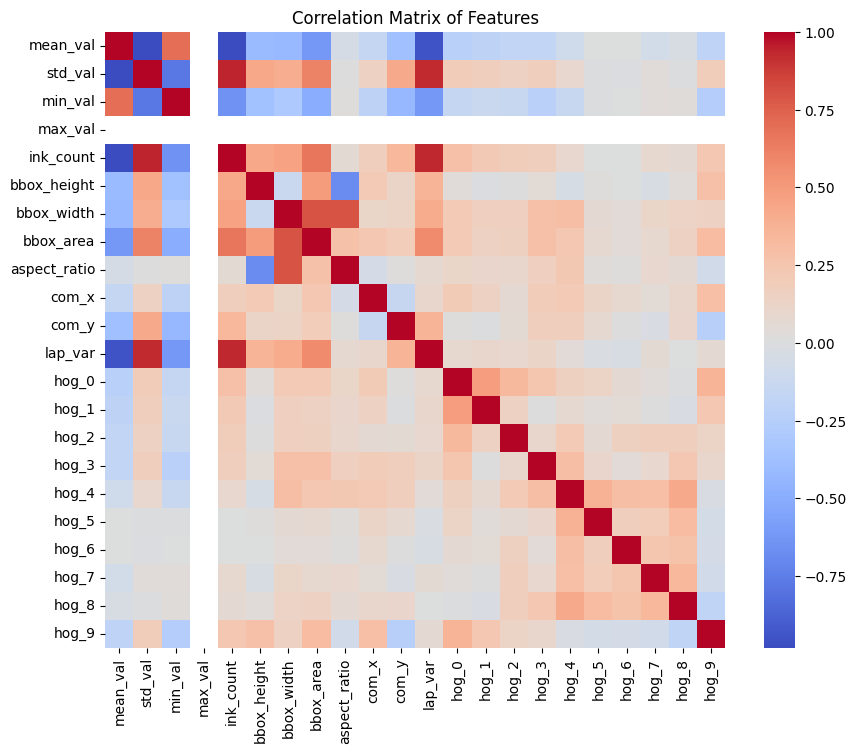

In [8]:
corr = df.drop(columns = ["label"]).corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr, cmap = "coolwarm", annot = False)
plt.title("Correlation Matrix of Features", fontsize = 12)
plt.show()

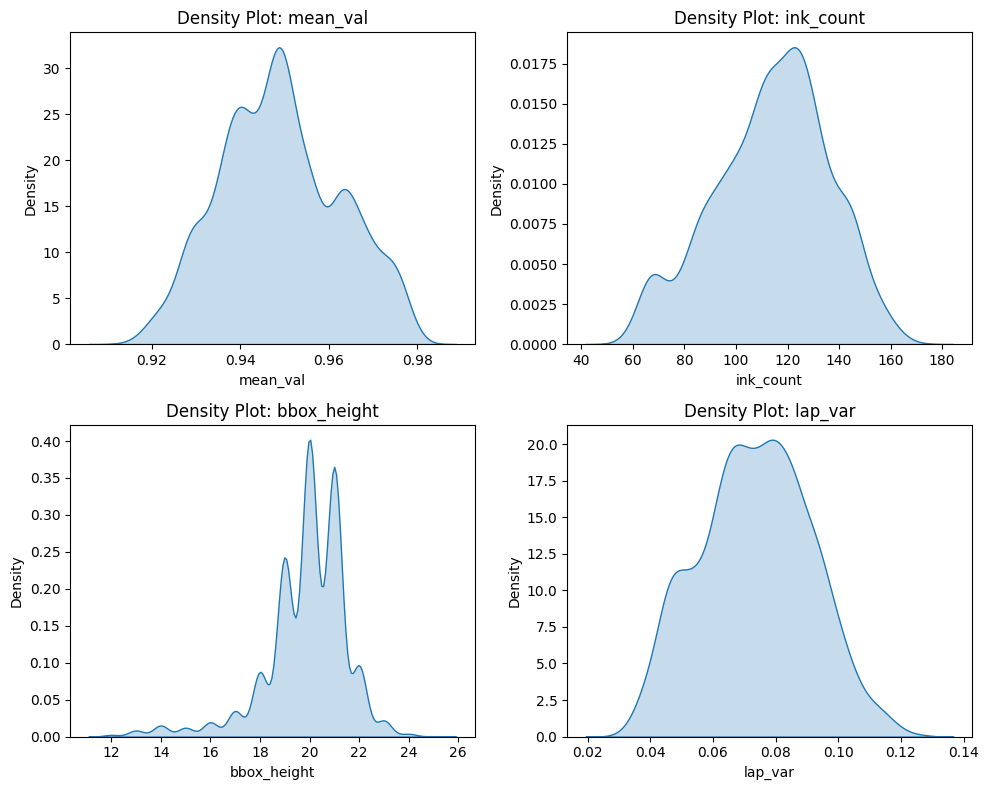

In [9]:
sample_features = ["mean_val", "ink_count", "bbox_height", "lap_var"]

plt.figure(figsize = (10, 8))
for i, ft in enumerate(sample_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(df[ft], fill = True)
    plt.title(f"Density Plot: {ft}")

plt.tight_layout()
plt.show()

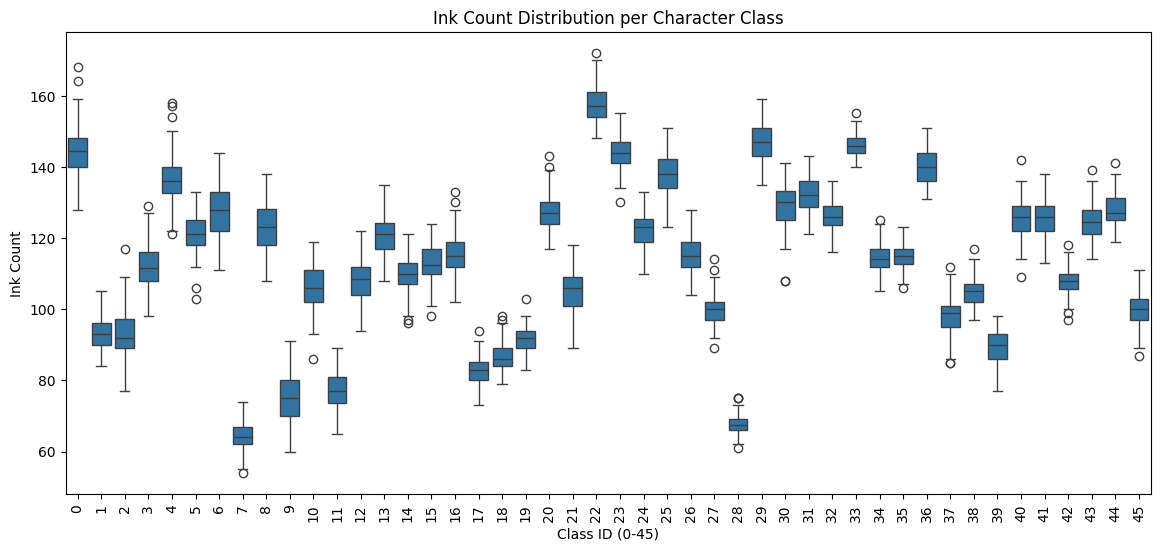

In [10]:
plt.figure(figsize = (14, 6))
sns.boxplot(data = df, x = "label", y = "ink_count")
plt.title("Ink Count Distribution per Character Class", fontsize = 12)
plt.xlabel("Class ID (0-45)")
plt.ylabel("Ink Count")
plt.xticks(rotation = 90)
plt.show()

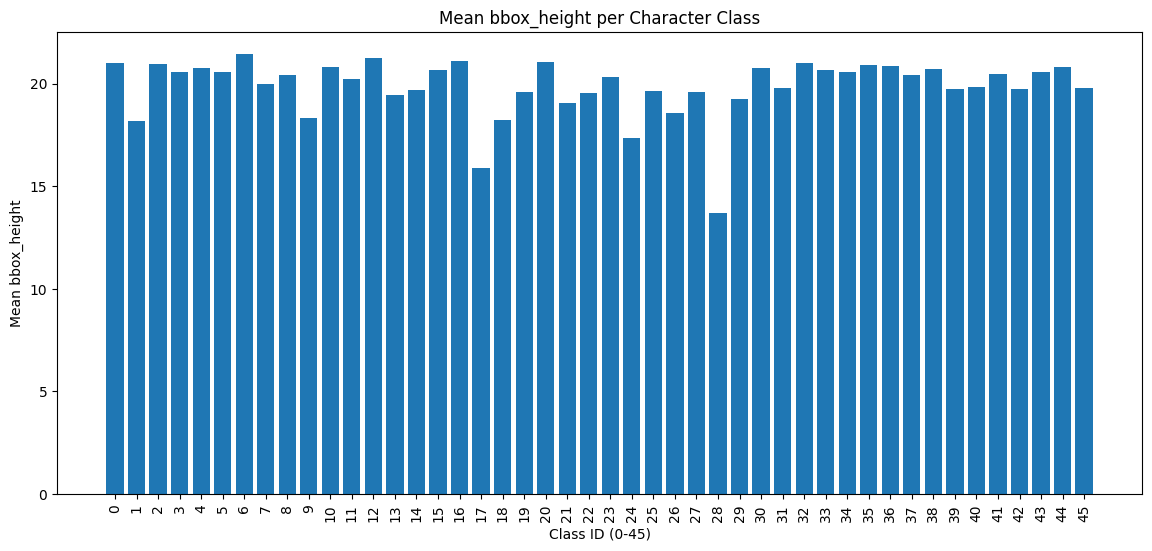

In [11]:

feature_to_plot = "bbox_height"

mean_per_class = df.groupby("label")[feature_to_plot].mean()

plt.figure(figsize = (14, 6))
plt.bar(range(len(mean_per_class)), mean_per_class)
plt.title(f"Mean {feature_to_plot} per Character Class", fontsize = 12)
plt.xlabel("Class ID (0-45)")
plt.ylabel(f"Mean {feature_to_plot}")
plt.xticks(range(46), rotation = 90)
plt.show()

In [12]:
def load_processed_image(path, target_size = (28, 28)):
    img = imread(path)
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, target_size, anti_aliasing = True).astype(np.float32)
    return img

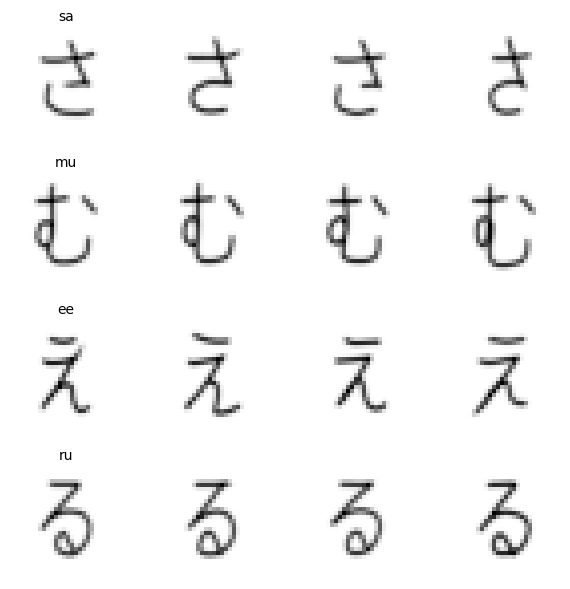

In [15]:
paths_by_class = {}
for p in image_paths:
    if p.parent.name not in paths_by_class:
        paths_by_class[p.parent.name] = []
    paths_by_class[p.parent.name].append(p)

classes_to_show = ["sa", "mu", "ee", "ru"]

fig, axes = plt.subplots(len(classes_to_show), 4, figsize=(6, 6))

for row, cls in enumerate(classes_to_show):
    sample_paths = random.sample(paths_by_class[cls], 4)
    for col, img_path in enumerate(sample_paths):
        ax = axes[row, col]
        img28 = load_processed_image(img_path)
        ax.imshow(img28, cmap="gray")
        ax.axis("off")
        if col == 0:
            ax.set_title(f"{cls}", fontsize=10)

plt.tight_layout()
plt.show()

## Splitting the dataset

I will split the dataset into:
- 70% training data
- 15% validation data (for hyperparameter tuning)
- 15% test data (for final evaluation)

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size = 0.30, 
    random_state = 42, 
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size = 0.50, 
    random_state = 42, 
    stratify = y_temp
)

## Feature Scaling

In this section, I scale my data as part of preprocessing. I fit the scaler only on the training set, then apply the same scaling
parameters to the validation set and test set.

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Dataset Shape Verification

Before training any models, I verify that the feature matrices and label arrays have the correct shapes after splitting and scaling. Each feature vector should have 22 features.

In [18]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

print("X_val_scaled shape:", X_val_scaled.shape)
print("y_val shape:", y_val.shape)

print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)
print("\n")

X_train_scaled shape: (3220, 22)
y_train shape: (3220,)
X_val_scaled shape: (690, 22)
y_val shape: (690,)
X_test_scaled shape: (690, 22)
y_test shape: (690,)




## LOGISTIC REGRESSION
### No Feature Transformation

In this section, I train a baseline multinomial Logistic Regression model.

In [19]:
logreg_results = []

In [20]:
C_values = [1e6, 1.0, 0.1, 0.01, 0.001, 0.0001]

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val, y_val_pred)
    val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "none",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
logreg_df

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,1000000.0000,0.996894,0.949275,0.950677,0.949275,0.948194
1,none,1.0000,0.970186,0.957971,0.960635,0.957971,0.957748
2,none,0.1000,0.943168,0.934783,0.939819,0.934783,0.934279
3,none,0.0100,0.870186,0.847826,0.860163,0.847826,0.844229
4,none,0.0010,0.621118,0.605797,0.697678,0.605797,0.572848
5,none,0.0001,0.445342,0.426087,0.557968,0.426087,0.376515


### Feature Transformaion: Polynomial Degree-2

In this section, I train a Logistic Regression model with feature transformation of degree 2. 

In [21]:
poly_two = PolynomialFeatures(degree = 2, include_bias = False)

X_train_poly_two = poly_two.fit_transform(X_train_scaled)
X_val_poly_two = poly_two.transform(X_val_scaled)

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_two, y_train)
    y_train_pred = model.predict(X_train_poly_two)
    y_val_pred   = model.predict(X_val_poly_two)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val, y_val_pred)
    val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_two",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_two_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_two"].copy()
polynomial_degree_two_df

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
6,polynomial_degree_two,1000000.0000,1.000000,0.918841,0.922822,0.918841,0.917467
7,polynomial_degree_two,1.0000,0.995652,0.946377,0.948345,0.946377,0.945570
8,polynomial_degree_two,0.1000,0.984161,0.946377,0.948612,0.946377,0.946053
9,polynomial_degree_two,0.0100,0.956522,0.928986,0.935151,0.928986,0.928192
10,polynomial_degree_two,0.0010,0.893789,0.869565,0.880931,0.869565,0.867989
11,polynomial_degree_two,0.0001,0.768323,0.731884,0.772087,0.731884,0.716328


### Feature Transformaion: Polynomial Degree-3

In this section, I train a Logistic Regression model with feature transformation of degree 3. 

In [22]:
poly_three = PolynomialFeatures(degree = 3, include_bias = False)

X_train_poly_three = poly_three.fit_transform(X_train_scaled)
X_val_poly_three = poly_three.transform(X_val_scaled)

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_three, y_train)
    y_train_pred = model.predict(X_train_poly_three)
    y_val_pred   = model.predict(X_val_poly_three)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val, y_val_pred)
    val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_three",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_three_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_three"].copy()
polynomial_degree_three_df

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
12,polynomial_degree_three,1000000.0000,1.000000,0.915942,0.919397,0.915942,0.915381
13,polynomial_degree_three,1.0000,0.999689,0.943478,0.945112,0.943478,0.942683
14,polynomial_degree_three,0.1000,0.995342,0.939130,0.941949,0.939130,0.938232
15,polynomial_degree_three,0.0100,0.981366,0.937681,0.941484,0.937681,0.937009
16,polynomial_degree_three,0.0010,0.950621,0.917391,0.923697,0.917391,0.915407
17,polynomial_degree_three,0.0001,0.880124,0.846377,0.856775,0.846377,0.843520


## Feature Transformation: K-Means Cluster

In this section, I train a Logistic Regression with feature transformation of K-Means Clusters.

In [23]:
def kmeans_transform(X):
    return kmeans.transform(X)

In [26]:
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans.fit(X_train_scaled)

X_train_km = np.hstack([X_train_scaled, kmeans_transform(X_train_scaled)])
X_val_km   = np.hstack([X_val_scaled, kmeans_transform(X_val_scaled)])
X_test_km  = np.hstack([X_test_scaled, kmeans_transform(X_test_scaled)])

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_km, y_train)

    y_train_pred = model.predict(X_train_km)
    y_val_pred = model.predict(X_val_km)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "kmeans_clusters",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
kmeans_clusters_df = logreg_df[logreg_df["transformation"] == "kmeans_clusters"].copy()
kmeans_clusters_df

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
30,kmeans_clusters,1000000.0000,0.997205,0.949275,0.951958,0.949275,0.948563
31,kmeans_clusters,1.0000,0.977019,0.959420,0.961631,0.959420,0.959125
32,kmeans_clusters,0.1000,0.948758,0.928986,0.934329,0.928986,0.928490
33,kmeans_clusters,0.0100,0.884472,0.862319,0.874724,0.862319,0.857401
34,kmeans_clusters,0.0010,0.769565,0.757971,0.780353,0.757971,0.741580
35,kmeans_clusters,0.0001,0.524845,0.521739,0.626507,0.521739,0.492941


## K-NEAREST NEIGHBORS
### No Transformation

In this section I train a baseline KNN model.

In [27]:
knn_results = []

In [28]:
k_values = [1, 3, 5, 7, 11, 15]

for k in k_values:
    model = KNeighborsClassifier(
        n_neighbors = k,
        weights = "uniform",
        metric = "euclidean"
    )

    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)
    

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val, y_val_pred)
    val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    
    knn_results.append({
        "transformation": "none",
        "k": k,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1,
    })

knn_df = pd.DataFrame(knn_results)
knn_df

,transformation,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,1,1.000000,0.901449,0.906178,0.901449,0.899519
1,none,3,0.955280,0.901449,0.904069,0.901449,0.899375
2,none,5,0.939130,0.902899,0.911713,0.902899,0.902309
3,none,7,0.921739,0.891304,0.897892,0.891304,0.889540
4,none,11,0.909627,0.878261,0.887642,0.878261,0.876774
5,none,15,0.893478,0.856522,0.869083,0.856522,0.855229
